In [1]:
#imports
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%run dataloader.ipynb

In [3]:
batch_size=2600
train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, collate_fn=collate_fn, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(test_set, collate_fn=collate_fn, batch_size=1000, shuffle=True)

In [4]:
gpu_id = 'cuda:5'
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')

In [5]:
# rnn
class RNN(torch.nn.Module):

    def __init__(self, input_dim_text, input_dim_speech, input_dim_visual, hidden_layer_size) -> None:
        super().__init__()

        self.text_rnn = torch.nn.LSTM(input_dim_text, hidden_layer_size, batch_first=True, num_layers=2, dropout=0.2)
        self.speech_rnn = torch.nn.LSTM(input_dim_speech, hidden_layer_size, batch_first=True, num_layers=2, dropout=0.2)
        self.visual_rnn = torch.nn.LSTM(input_dim_visual, hidden_layer_size, batch_first=True, num_layers=2, dropout=0.2)
        self.dropout = torch.nn.Dropout(0.2)
        self.linear = torch.nn.Linear(hidden_layer_size, 1)

    def forward(self, x_text, x_speech, x_visual, text_lens):
        batch_size = x_text.shape[0]

        interm_states_text, _ = self.text_rnn(x_text)
        interm_states_speech, _ = self.speech_rnn(x_speech)
        interm_states_visual, _ = self.visual_rnn(x_visual)

        final_state_text = interm_states_text[torch.arange(batch_size), text_lens - 1, :]
        final_state_speech = interm_states_speech[torch.arange(batch_size), text_lens - 1, :]
        final_state_visual = interm_states_visual[torch.arange(batch_size), text_lens - 1, :]

        stacked = torch.stack((
            final_state_text, 
            final_state_speech,
            final_state_visual
            ), dim=1)
        pooled = torch.max(stacked, dim=1)[0]
        h = self.dropout(pooled)
        return self.linear(h)

step error


/tmp/ipykernel_3372217/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3372217/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3372217/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

1 0.6913546919822693
dev error:  0.6923770904541016
2 0.6897344589233398
dev error:  0.691652238368988
3 0.6875655055046082
dev error:  0.6906182169914246
4 0.6858721375465393
dev error:  0.6895639896392822
5 0.6828481554985046
dev error:  0.6883695125579834
6 0.6822584867477417
dev error:  0.687321126461029
7 0.6773380637168884
dev error:  0.6852231621742249
8 0.6725885272026062
dev error:  0.6827043890953064
9 0.6693484783172607
dev error:  0.6806206703186035
10 0.6617922782897949
dev error:  0.6756903529167175
11 0.6503181457519531
dev error:  0.6738857626914978
12 0.6323065161705017
dev error:  0.6754294037818909
13 0.6348106861114502
dev error:  0.6684474945068359
14 0.6351767778396606
dev error:  0.6637443900108337
15 0.6248255372047424
dev error:  0.6623566150665283
16 0.6286011934280396
dev error:  0.6576001644134521
17 0.6336697340011597
dev error:  0.6562966108322144
18 0.6255604028701782
dev error:  0.6553303003311157
19 0.6232975125312805
dev error:  0.6598345637321472
20 0

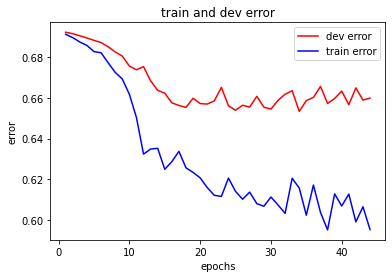

best model after 34 epochs with dev set error 0.6533867716789246


In [6]:
# input features
###
idxs_text = torch.arange(300) # text, 300
idxs_speech = torch.arange(300, 381) # speech, 81
idxs_visual = torch.arange(381, 752) # visual, 371

device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')
model = RNN(input_dim_text=300, input_dim_speech=81, input_dim_visual=371, hidden_layer_size=256)
model.to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.002)
epochs = 100
patience = 10

print('step', 'error')
dev_errors = []
best_dev_error = np.inf
errors = []
num_bad_epochs = 0
num_epochs = 0
best_epoch = 0
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, batch in enumerate(train_dataloader, 0):
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        optimiser.zero_grad()
        output = model(x_p[:, :, idxs_text], x_p[:, :, idxs_speech], x_p[:, :, idxs_visual], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        model.eval()
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0):
            x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
            dev_output = model(x_p[:, :, idxs_text], x_p[:, :, idxs_speech], x_p[:, :, idxs_visual], x_p_len)
            dev_error = torch.nn.functional.binary_cross_entropy_with_logits(dev_output, y)
        dev_errors.append(float(dev_error))
        print('dev error: ', float(dev_error))

    if dev_error < best_dev_error:
        num_bad_epochs = 0
        best_dev_error = dev_error
        best_epoch = epoch
        torch.save(model, 'punchline_net_all.pth')
    else:
        num_bad_epochs += 1
        if num_bad_epochs == patience:
            num_epochs = epoch
            break

plt.plot(range(1, num_epochs+1), dev_errors, 'r', label='dev error')
plt.plot(range(1, num_epochs+1), errors, 'b', label='train error')
plt.title('train and dev error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()
plt.show()

print('best model after {} epochs with dev set error {}'.format(best_epoch, best_dev_error))
model = torch.load('punchline_net_all.pth')

In [7]:
hid_humor_t = {}
hid_humor_f = {}
hid_nonhumor_t = {}
hid_nonhumor_f = {}

with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid, x_p_len=map(lambda x: x.to(device), batch)
        output = model(x_p[:, :, idxs_text], x_p[:, :, idxs_speech], x_p[:, :, idxs_visual], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        scaled_outputs = torch.sigmoid(output)
        predictions = (scaled_outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
        for j, id in enumerate(hid.detach().tolist()):
            if predictions[j] == 1 and y[j] == 1:
                hid_humor_t[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 1 and y[j] == 0:
                hid_humor_f[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 0:
                hid_nonhumor_t[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 1:
                hid_nonhumor_f[id] = scaled_outputs[j].detach().tolist()[0]
            else:
                print('something is wrong')
    acc = matches / total
    print('test error: ', float(error))
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_3372217/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3372217/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3372217/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

test error:  0.6274634003639221
test accuracy: 65.20%


In [8]:
print(len(hid_humor_t))
print(len(hid_nonhumor_t))
print(len(hid_humor_f))
print(len(hid_nonhumor_f))

language_sdk=load_pickle("language_sdk.pkl")

sorted_humor_t = {k: v for k, v in sorted(hid_humor_t.items(), key=lambda item: item[1], reverse=True)}
sorted_nonhumor_t = {k: v for k, v in sorted(hid_nonhumor_t.items(), key=lambda item: item[1], reverse=True)}
sorted_humor_f = {k: v for k, v in sorted(hid_humor_f.items(), key=lambda item: item[1], reverse=True)}
sorted_nonhumor_f = {k: v for k, v in sorted(hid_nonhumor_f.items(), key=lambda item: item[1], reverse=True)}

for hid, output in list(sorted_humor_t.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_humor_f.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_nonhumor_t.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_nonhumor_f.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])

346
293
197
144
so had the graduate heard the right one word maybe he would have ended up onstage oh i don't know maybe with these two
this is why spouses in happy marriages tend to think that their husband or wife looks much better than anyone else thinks that they do
and as the saying goes when angry you will make the best speech you will ever regret
we had one government agency and one company aircraft operator say you're crazy don't do that you're going kill the guy
as a multi purpose passenger vehicle it is now officially designed for occasional off road use

oh let me kind of tell you a funny little play bit
i would have told you myself that i was the last person on earth who would stay with a man who beats me but in fact i was a very typical victim because of my age
but if you think the is something like a wasteland i think it's wrong
it's also good news if you want to browse for illegal pornography and if you want to buy and sell drugs with impunity
ok but don't say my name lik